# New Section

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dsettu/tflite/blob/main/har_basic/har_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dsettu/tflite/blob/main/har_basic/har_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import os
import sys
import sklearn as sk
print(f"Tensor Flow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-Learn version: {sk.__version__}")
print("GPU is", "Available" if tf.test.is_gpu_available() else "Not Available")


Tensor Flow version: 2.3.0
Keras version: 2.4.0
Python version: 3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]
Pandas version: 1.1.2
Scikit-Learn version: 0.22.2.post1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is Not Available


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load dataset

In [ ]:

path = "/content/drive/My Drive/tfData/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt"

file = open(path)
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line=line.split(',')
        last=line[5].split(';')[0]
        last=last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number ',i)


Error at line number  281873
Error at line number  281874
Error at line number  281875


In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/HAR/datasets/WISDM_ar_v1.1_raw.txt"
columns = ['User', 'Activity_Label', 'Arrival_Time', 'x', 'y', 'z'] # headers for the columns
dataset = pd.read_csv(path, header=None, names=columns )
print(dataset)

         User Activity_Label  ...          y             z
0          33        Jogging  ...  12.680544   0.50395286;
1          33        Jogging  ...  11.264028   0.95342433;
2          33        Jogging  ...  10.882658  -0.08172209;
3          33        Jogging  ...  18.496431    3.0237172;
4          33        Jogging  ...  12.108489     7.205164;
...       ...            ...  ...        ...           ...
1098199    19        Sitting  ...  -1.570000         1.69;
1098200    19        Sitting  ...  -1.460000         1.73;
1098201    19        Sitting  ...  -1.380000         1.69;
1098202    19        Sitting  ...  -1.460000         1.73;
1098203    19        Sitting  ...  -1.330000         1.61;

[1098204 rows x 6 columns]


### Remove user and time information

In [ ]:
columns = ['user', 'activity', 'time','x','y','z']
data = pd.DataFrame(data=processedList, columns = columns)
data.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [ ]:
df=data.drop(['user','time'], axis = 1).copy()
df.head()


,activity,x,y,z
0,Jogging,-0.6946377,12.680544,0.50395286
1,Jogging,5.012288,11.264028,0.95342433
2,Jogging,4.903325,10.882658,-0.08172209
3,Jogging,-0.61291564,18.496431,3.0237172
4,Jogging,-1.1849703,12.108489,7.205164


### Balance the dataset equally for all activities

In [ ]:
df['activity'].value_counts()

Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
Name: activity, dtype: int64

In [ ]:
Walking = df[df['activity']=='Walking'].head(3555).copy()
Jogging = df[df['activity']=='Jogging'].head(3555).copy()
Upstairs = df[df['activity']=='Upstairs'].head(3555).copy()
Downstairs = df[df['activity']=='Downstairs'].head(3555).copy()
Sitting = df[df['activity']=='Sitting'].head(3555).copy()
Standing = df[df['activity']=='Standing'].head(3555).copy()

balanced_data=pd.DataFrame()
balanced_data = balanced_data.append ([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])
balanced_data['activity'].value_counts()

Standing      3555
Upstairs      3555
Downstairs    3555
Walking       3555
Sitting       3555
Jogging       3555
Name: activity, dtype: int64

### Convert the X,Y,Z data to float 

In [ ]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21330 entries, 597 to 257322
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   activity  21330 non-null  object
 1   x         21330 non-null  object
 2   y         21330 non-null  object
 3   z         21330 non-null  object
dtypes: object(4)
memory usage: 833.2+ KB


In [ ]:
balanced_data['x']=balanced_data['x'].astype('float')
balanced_data['y']=balanced_data['y'].astype('float')
balanced_data['z']=balanced_data['z'].astype('float')
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21330 entries, 597 to 257322
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   activity  21330 non-null  object 
 1   x         21330 non-null  float64
 2   y         21330 non-null  float64
 3   z         21330 non-null  float64
dtypes: float64(3), object(1)
memory usage: 833.2+ KB


### Add label to the data

In [ ]:
balanced_data.head()

,activity,x,y,z
597,Walking,0.844462,8.008764,2.792171
598,Walking,1.116869,8.621680,3.786457
599,Walking,-0.503953,16.657684,1.307553
600,Walking,4.794363,10.760075,-1.184970
601,Walking,-0.040861,9.234595,-0.694638


In [ ]:
label=LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['activity'])
balanced_data.head()

,activity,x,y,z,label
597,Walking,0.844462,8.008764,2.792171,5
598,Walking,1.116869,8.621680,3.786457,5
599,Walking,-0.503953,16.657684,1.307553,5
600,Walking,4.794363,10.760075,-1.184970,5
601,Walking,-0.040861,9.234595,-0.694638,5


In [ ]:
label.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

### Normalize the input data

In [ ]:
x = balanced_data[['x','y','z']]
y = balanced_data['label']

scaler = StandardScaler()
X = scaler.fit_transform(x)

scaled_X = pd.DataFrame(data=X, columns = ['x','y','z'])
scaled_X['label']=y.values

scaled_X.head()

,x,y,z,label
0,0.000503,-0.099190,0.337933,5
1,0.073590,0.020386,0.633446,5
2,-0.361275,1.588160,-0.103312,5
3,1.060258,0.437573,-0.844119,5
4,-0.237028,0.139962,-0.698386,5


### Convert to frames (80 samples of X, Y, Z)

In [ ]:
Fs = 20
frame_size = Fs*4  # 80 samples
hop_size = Fs*2    # 40 samples

def get_frames(df, framesize, hop_size):
    N_FEATURES = 3
    
    frames = []
    labels = []
    
    for i in range (0, len(df) - frame_size, hop_size):
        x = df['x'].values[i:i+frame_size]
        y = df['y'].values[i:i+frame_size]
        z = df['z'].values[i:i+frame_size]
        
        # Retrive the most often used label in this segment
        label = stats.mode(df['label'][i:i+frame_size])[0][0]
        frames.append([x,y,z])
        labels.append(label)
        
    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1,frame_size, N_FEATURES)
    labels = np.asarray(labels)
    
    return frames, labels


X, y = get_frames(scaled_X, frame_size, hop_size)

### Split data set for training and validation. Reshape it to use with CNN model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train.shape, X_test.shape

((425, 80, 3), (107, 80, 3))

In [ ]:
X_train = X_train.reshape(425,80,3,1)
X_test = X_test.reshape(107,80,3,1)
X_train.shape, X_test.shape

((425, 80, 3, 1), (107, 80, 3, 1))

### Create CNN Model

In [ ]:
model = Sequential()
model.add(Conv2D(16,kernel_size=(2,2), padding='valid', activation = 'relu', input_shape=(80,3,1)))
model.add(Dropout(0.1))

model.add(Conv2D(32,kernel_size=(2,2), padding='valid', activation = 'relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6,activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 79, 2, 16)         80        
_________________________________________________________________
dropout (Dropout)            (None, 79, 2, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 78, 1, 32)         2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 78, 1, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2496)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                159808    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

### Train Model

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs =10, validation_data = (X_test, y_test), verbose=1)

Epoch 1/10
14/14 [==============================] - 0s 21ms/step - loss: 1.6390 - accuracy: 0.2612 - val_loss: 1.3530 - val_accuracy: 0.4673
Epoch 2/10
14/14 [==============================] - 0s 12ms/step - loss: 1.2638 - accuracy: 0.5176 - val_loss: 1.0033 - val_accuracy: 0.7103
Epoch 3/10
14/14 [==============================] - 0s 11ms/step - loss: 1.0219 - accuracy: 0.6494 - val_loss: 0.7160 - val_accuracy: 0.7477
Epoch 4/10
14/14 [==============================] - 0s 12ms/step - loss: 0.7678 - accuracy: 0.7176 - val_loss: 0.5354 - val_accuracy: 0.8411
Epoch 5/10
14/14 [==============================] - 0s 11ms/step - loss: 0.6547 - accuracy: 0.7506 - val_loss: 0.4102 - val_accuracy: 0.8972
Epoch 6/10
14/14 [==============================] - 0s 10ms/step - loss: 0.4970 - accuracy: 0.8306 - val_loss: 0.3354 - val_accuracy: 0.8785
Epoch 7/10
14/14 [==============================] - 0s 11ms/step - loss: 0.4685 - accuracy: 0.8329 - val_loss: 0.2907 - val_accuracy: 0.8785
Epoch 8/10
14

### Plot Learning Curve

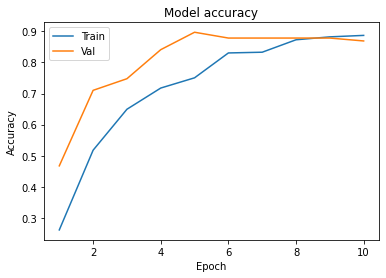

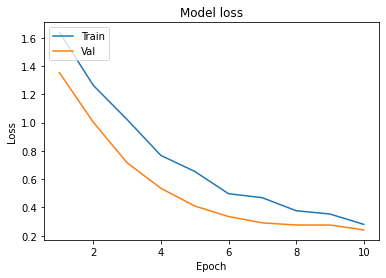

In [ ]:
def plot_learningCurve(history, epochs):
    # Plot training & validation accuracy values
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

plot_learningCurve(history, 10)

### Plot Confusion Matrix

In [ ]:
!pip install mlxtend

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2c81e3ce80>)

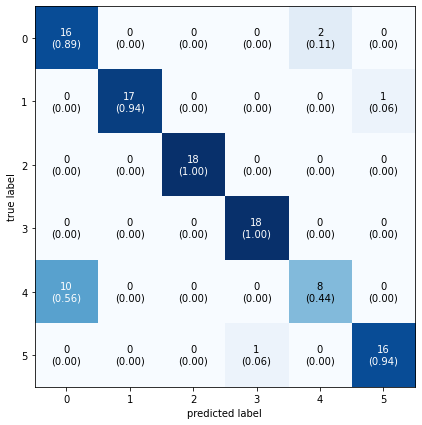

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib

y_pred = np.argmax(model.predict(X_test), axis=-1) 
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, show_normed=True, figsize=(7,7))

### Convert to a TensorFlow Lite model - without quantization


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

modelfile = "/content/drive/My Drive/tfModel/har_model.tflite"
open(modelfile, "wb").write(tflite_model)


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp7471wqdb/assets


652028

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2c81d8d630>)

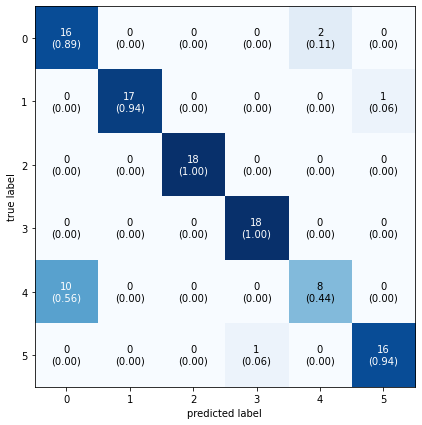

In [ ]:
# Initialize an interpreter with the model
modelfile = "/content/drive/My Drive/tfModel/har_model.tflite"
interpreter = tf.lite.Interpreter(modelfile)

# Allocate memory for the model's input Tensor's
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]


# Create arrays to store the results
har_model_predictions = []

# Inference with Tensorflow Lite model
for i in range(len(X_test)):
  input = X_test[i].reshape(1,80,3,1)
  input = input.astype(np.float32)

  x_value_tensor = tf.convert_to_tensor(input, dtype=tf.float32)
  interpreter.set_tensor(input_index, x_value_tensor)
  interpreter.invoke()
  har_model_predictions.append(interpreter.get_tensor(output_index)[0])

# Plot Confusion matrix
y_pred=np.argmax(har_model_predictions, axis=1)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, show_normed=True, figsize=(7,7))

### Convert to a TensorFlow Lite model - using float fallback quantization

In [ ]:
def representative_dataset_gen():
    for i in range(len(X_train)):
      input = X_train[i].reshape(1,80,3,1)
      input = input.astype(np.float32)
      yield [input]
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_dataset_gen

tflite_model_quant1 = converter.convert()

modelfile = "/content/drive/My Drive/tfModel/har_model_quant1.tflite"
open(modelfile, "wb").write(tflite_model_quant1)

INFO:tensorflow:Assets written to: /tmp/tmpf1dq6hfn/assets


INFO:tensorflow:Assets written to: /tmp/tmpf1dq6hfn/assets


168000

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2c86612550>)

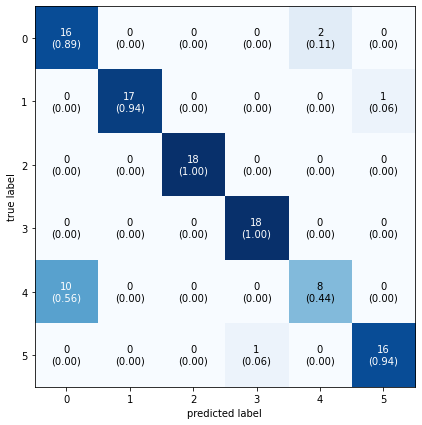

In [ ]:
# Initialize an interpreter with the model
modelfile = "/content/drive/My Drive/tfModel/har_model_quant1.tflite"
interpreter = tf.lite.Interpreter(modelfile)

# Allocate memory for the model's input Tensor's
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]


# Create arrays to store the results
har_model_predictions = []

# Inference with Tensorflow Lite model
for i in range(len(X_test)):
  input = X_test[i].reshape(1,80,3,1)
  input = input.astype(np.float32)

  #x_value_tensor = tf.convert_to_tensor(input, dtype=tf.float32)
  interpreter.set_tensor(input_index, input)
  interpreter.invoke()
  har_model_predictions.append(interpreter.get_tensor(output_index)[0])

# Plot Confusion matrix
y_pred=np.argmax(har_model_predictions, axis=1)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, show_normed=True, figsize=(7,7))

### Convert to a TensorFlow Lite model - using integer-only quantization

In [ ]:
def representative_dataset_gen():
    for i in range(len(X_train)):
      input = X_train[i].reshape(1,80,3,1)
      input = input.astype(np.float32)
      yield [input]

converter=tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_dataset_gen

# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, 
# we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
# Provide a representative dataset to ensure we quantize correctly.
tflite_model_quant2 = converter.convert()

modelfile = "/content/drive/My Drive/tfModel/har_model_quant2.tflite"
open(modelfile, "wb").write(tflite_model_quant2)

INFO:tensorflow:Assets written to: /tmp/tmpjb78j2u4/assets


INFO:tensorflow:Assets written to: /tmp/tmpjb78j2u4/assets


167744

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2c8660ce80>)

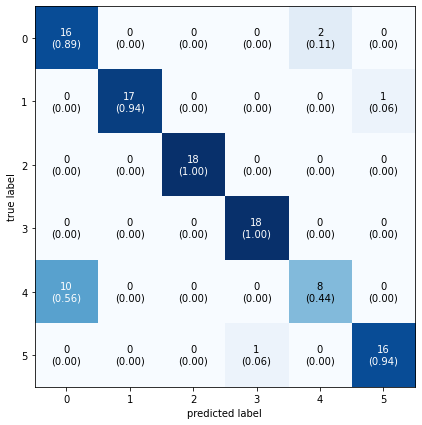

In [ ]:
# Initialize an interpreter with the model
modelfile = "/content/drive/My Drive/tfModel/har_model_quant2.tflite"
interpreter = tf.lite.Interpreter(modelfile)

# Allocate memory for the model's input Tensor's
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

# Create arrays to store the results
har_model_predictions = []

# Inference with Tensorflow Lite model
for i in range(len(X_test)):
  tf_input = X_test[i].reshape(1,80,3,1)
  tf_input = tf_input.astype(np.float32)

# Manually quantize the input from float to integer
  scale, zero_point = input_details['quantization']
  tflite_integer_input = tf_input / scale + zero_point
  tflite_integer_input = tflite_integer_input.astype(input_details['dtype'])
  interpreter.set_tensor(input_details['index'], tflite_integer_input)

  interpreter.invoke()

  output_details = interpreter.get_output_details()[0]
  tflite_integer_output = interpreter.get_tensor(output_details['index'])
  # Manually dequantize the output from integer to float
  scale, zero_point = output_details['quantization']
  tflite_output = tflite_integer_output.astype(np.float32)
  tflite_output = (tflite_output - zero_point) * scale

  har_model_predictions.append(tflite_output[0])

# Plot Confusion matrix
y_pred=np.argmax(har_model_predictions, axis=1)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, show_normed=True, figsize=(7,7))

### Generate C file

In [ ]:
from tensorflow.lite.python.util import convert_bytes_to_c_source
source_text, header_text = convert_bytes_to_c_source(tflite_model,  "har_model")

hfile = "/content/drive/My Drive/tfModel/har_model.h"
cfile = "/content/drive/My Drive/tfModel/har_model.cpp"

with  open(hfile,  'w')  as  file:
    file.write(header_text)

with  open(cfile,  'w')  as  file:
    file.write(source_text)

In [ ]:
from tensorflow.lite.python.util import convert_bytes_to_c_source
source_text, header_text = convert_bytes_to_c_source(tflite_model_quant1,  "har_model")

hfile = "/content/drive/My Drive/tfModel/har_model_quant1.h"
cfile = "/content/drive/My Drive/tfModel/har_model_quant1.cpp"

with  open(hfile,  'w')  as  file:
    file.write(header_text)

with  open(cfile,  'w')  as  file:
    file.write(source_text)

In [ ]:
from tensorflow.lite.python.util import convert_bytes_to_c_source
source_text, header_text = convert_bytes_to_c_source(tflite_model_quant2,  "har_model")

hfile = "/content/drive/My Drive/tfModel/har_model_quant2.h"
cfile = "/content/drive/My Drive/tfModel/har_model_quant2.cpp"

with  open(hfile,  'w')  as  file:
    file.write(header_text)

with  open(cfile,  'w')  as  file:
    file.write(source_text)

In [ ]:
model = Sequential()
model.add(Conv2D(24, kernel_size=(3,3), padding='same', activation = 'relu', input_shape = (32,32,3)))
model.add(Conv2D(24, kernel_size=(3,3), padding='same', activation = 'relu'))
model.add(Conv2D(24, kernel_size=(3,3), padding='same', activation = 'relu'))
model.add(Flatten())
model.add(Dense(1, activation = 'relu'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 24)        672       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 24)        5208      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 24)        5208      
_________________________________________________________________
flatten_1 (Flatten)          (None, 24576)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 24577     
Total params: 35,665
Trainable params: 35,665
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Sequential()
model.add(Conv2D(24, kernel_size=(16, 1), input_shape=(24,3,1), activation='relu'))
model.add(MaxPool2D( pool_size = (3, 1)))
model.add(Flatten())
model.add(Dense(12) )
model.add(Dropout(0.5))
model.add(Dense(4, activation = 'softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 9, 3, 24)          408       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 24)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 216)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                2604      
_________________________________________________________________
dropout_3 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 52        
Total params: 3,064
Trainable params: 3,064
Non-trainable params: 0
____________________________________________________

In [ ]:
y_pred

array([4, 2, 2, 1, 1, 1, 5, 0, 2, 4, 3, 2, 0, 2, 3, 2, 1, 1, 2, 5, 0, 5,
       5, 1, 1, 0, 5, 3, 3, 1, 0, 0, 4, 5, 2, 5, 2, 1, 1, 2, 2, 5, 0, 0,
       0, 0, 2, 3, 3, 3, 2, 4, 5, 4, 0, 3, 3, 0, 3, 4, 0, 1, 1, 0, 1, 2,
       1, 0, 3, 3, 3, 5, 0, 4, 4, 0, 5, 2, 3, 5, 4, 3, 3, 4, 0, 3, 0, 3,
       5, 5, 5, 0, 2, 1, 0, 0, 3, 0, 0, 1, 2, 5, 0, 5, 1, 0, 2])